In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [97]:
import os
import json
import logging
from collections import defaultdict
from typing import List, Tuple, Dict, Optional, Any, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# **1- Configuration**

In [98]:
class Config:
    def __init__(self):
        # Model
        self.EMBED_DIM = 64
        self.NUM_LAYERS = 2
        self.REG_LAMBDA = 1e-3

        # Training
        self.EPOCHS = 50
        self.BATCH_SIZE = 2048
        self.LEARNING_RATE = 1e-3
        self.PATIENCE = 10
        self.VALIDATION_SPLIT = 0.1
        self.GRADIENT_CLIP = 1.0

        # Data
        self.MIN_RATING = 4.0
        self.RANDOM_SEED = 42
        self.DATA_PATH = "/kaggle/input/flipkart-laptop-reviews/laptops_dataset_final_600.csv"  

        # Evaluation
        self.TOP_K_VALUES = [5, 10, 20]

        # Paths
        self.MODEL_SAVE_DIR = "./models"
        self.MODEL_BEST_PATH = os.path.join(self.MODEL_SAVE_DIR, "lightgcn_best.pt")
        self.CONFIG_SAVE_PATH = os.path.join(self.MODEL_SAVE_DIR, "config.json")
        self.MAPPING_SAVE_PATH = os.path.join(self.MODEL_SAVE_DIR, "mapping.json")

        # LR scheduler
        self.USE_LR_SCHEDULER = True
        self.LR_SCHEDULER_PATIENCE = 5
        self.LR_SCHEDULER_FACTOR = 0.5

        # Negative sampling
        self.NUM_NEGATIVES = 1

    def to_dict(self) -> Dict[str, Any]:
        return {
            "EMBED_DIM": self.EMBED_DIM,
            "NUM_LAYERS": self.NUM_LAYERS,
            "REG_LAMBDA": self.REG_LAMBDA,
            "EPOCHS": self.EPOCHS,
            "BATCH_SIZE": self.BATCH_SIZE,
            "LEARNING_RATE": self.LEARNING_RATE,
            "PATIENCE": self.PATIENCE,
            "VALIDATION_SPLIT": self.VALIDATION_SPLIT,
            "GRADIENT_CLIP": self.GRADIENT_CLIP,
            "MIN_RATING": self.MIN_RATING,
            "RANDOM_SEED": self.RANDOM_SEED,
            "TOP_K_VALUES": self.TOP_K_VALUES,
            "DATA_PATH": self.DATA_PATH,
            "MODEL_SAVE_DIR": self.MODEL_SAVE_DIR,
            "MODEL_BEST_PATH": self.MODEL_BEST_PATH,
            "CONFIG_SAVE_PATH": self.CONFIG_SAVE_PATH,
            "MAPPING_SAVE_PATH": self.MAPPING_SAVE_PATH,
            "USE_LR_SCHEDULER": self.USE_LR_SCHEDULER,
            "LR_SCHEDULER_PATIENCE": self.LR_SCHEDULER_PATIENCE,
            "LR_SCHEDULER_FACTOR": self.LR_SCHEDULER_FACTOR,
            "NUM_NEGATIVES": self.NUM_NEGATIVES,
        }

    @classmethod
    def from_dict(cls, d: Dict[str, Any]) -> "Config":
        cfg = cls()
        for k, v in d.items():
            if hasattr(cfg, k):
                setattr(cfg, k, v)
        return cfg

# **2- LightGCN propagation**

In [99]:
def lightgcn_propagate(x: Tensor, edge_index: Tensor) -> Tensor:
    """
    Symmetric normalized message passing for LightGCN.
    x: [num_nodes, dim]
    edge_index: [2, num_edges]
    """
    row, col = edge_index
    num_nodes = x.size(0)
    device = x.device

    deg = torch.zeros(num_nodes, dtype=torch.float32, device=device)
    deg.index_add_(0, row, torch.ones_like(row, dtype=torch.float32, device=device))

    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt = torch.clamp(deg_inv_sqrt, min=1e-12)

    norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

    msg = x[row] * norm.unsqueeze(-1)
    out = torch.zeros_like(x)
    out.index_add_(0, col, msg)

    return out

# **3- LightGCN model**

In [100]:
class LightGCN(nn.Module):
    def __init__(self, num_users: int, num_items: int, embed_dim: int, num_layers: int):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(num_users + num_items, embed_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        logger.info(
            f"LightGCN initialized | users={num_users}, items={num_items}, "
            f"embed_dim={embed_dim}, layers={num_layers}"
        )

    def forward(self, edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        x = self.embedding.weight
        all_embs = [x]

        for _ in range(self.num_layers):
            x = lightgcn_propagate(x, edge_index)
            all_embs.append(x)

        final_emb = torch.mean(torch.stack(all_embs, dim=1), dim=1)
        user_emb = final_emb[: self.num_users]
        item_emb = final_emb[self.num_users :]

        return user_emb, item_emb

    @torch.no_grad()
    def get_embeddings(self, edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        self.eval()
        return self.forward(edge_index)

    @torch.no_grad()
    def recommend(
        self,
        edge_index: Tensor,
        user_id: int,
        seen_items: Union[set, List[int]],
        k: int = 10,
    ) -> List[int]:
        self.eval()
        user_emb, item_emb = self.forward(edge_index)
        user_vec = user_emb[user_id : user_id + 1]
        scores = torch.matmul(user_vec, item_emb.T).squeeze(0)

        if seen_items:
            seen_list = list(seen_items)
            scores[seen_list] = -float("inf")

        k = min(k, scores.size(0))
        topk = torch.topk(scores, k).indices.tolist()
        return topk

# **4- BPR loss**

In [101]:
def bpr_loss(
    u_emb: Tensor, pos_emb: Tensor, neg_emb: Tensor, reg_lambda: float
) -> Tensor:
    pos_scores = (u_emb * pos_emb).sum(dim=-1)
    neg_scores = (u_emb * neg_emb).sum(dim=-1)
    loss = -F.logsigmoid(pos_scores - neg_scores).mean()

    reg = reg_lambda * (
        u_emb.pow(2).sum() + pos_emb.pow(2).sum() + neg_emb.pow(2).sum()
    ) / u_emb.size(0)

    return loss + reg

# **5- Metrics**

In [102]:
class Metrics:
    @staticmethod
    def recall_at_k(recommended: List[int], relevant: set, k: int) -> float:
        if not relevant:
            return 0.0
        rec_k = recommended[:k]
        hits = len(set(rec_k) & relevant)
        return hits / len(relevant)

    @staticmethod
    def precision_at_k(recommended: List[int], relevant: set, k: int) -> float:
        if k == 0:
            return 0.0
        rec_k = recommended[:k]
        hits = len(set(rec_k) & relevant)
        return hits / k

    @staticmethod
    def ndcg_at_k(recommended: List[int], relevant: set, k: int) -> float:
        if not relevant:
            return 0.0
        rec_k = recommended[:k]
        dcg = 0.0
        for i, item in enumerate(rec_k):
            if item in relevant:
                dcg += 1.0 / np.log2(i + 2)
        ideal_len = min(len(relevant), k)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_len))
        return dcg / idcg if idcg > 0 else 0.0

    @staticmethod
    def compute_all(recommended: List[int], relevant: set, ks: List[int]) -> Dict[str, float]:
        out = {}
        for k in ks:
            out[f"recall@{k}"] = Metrics.recall_at_k(recommended, relevant, k)
            out[f"precision@{k}"] = Metrics.precision_at_k(recommended, relevant, k)
            out[f"ndcg@{k}"] = Metrics.ndcg_at_k(recommended, relevant, k)
        return out

# **6- Dataset**

In [103]:
class BPRDataset(Dataset):
    def __init__(
        self,
        interactions: List[Tuple[int, int]],
        num_items: int,
        num_negatives: int = 1,
    ):
        self.interactions = interactions
        self.num_items = num_items
        self.num_negatives = num_negatives

        self.user_pos = defaultdict(set)
        for u, i in interactions:
            self.user_pos[u].add(i)

        self.all_items = np.arange(num_items, dtype=np.int64)

    def __len__(self) -> int:
        return len(self.interactions)

    def __getitem__(self, idx: int) -> Tuple[int, int, int]:
        u, pos = self.interactions[idx]
        pos_set = self.user_pos[u]

        while True:
            neg = np.random.randint(0, self.num_items)
            if neg not in pos_set:
                break

        return u, pos, neg

# **7- Training & validation**

In [104]:
def validate_model(
    model: LightGCN,
    edge_index: Tensor,
    val_interactions: List[Tuple[int, int]],
    config: Config,
) -> float:
    model.eval()
    device = next(model.parameters()).device
    edge_index = edge_index.to(device)

    # Forward once (no backward in validation)
    user_emb, item_emb = model(edge_index)

    user_pos = defaultdict(list)
    for u, i in val_interactions:
        user_pos[u].append(i)

    total_loss = 0.0
    count = 0

    for u, items in user_pos.items():
        for pos in items:
            neg = np.random.randint(0, model.num_items)
            while neg in items:
                neg = np.random.randint(0, model.num_items)

            u_e = user_emb[u : u + 1]
            pos_e = item_emb[pos : pos + 1]
            neg_e = item_emb[neg : neg + 1]

            loss = bpr_loss(u_e, pos_e, neg_e, config.REG_LAMBDA)
            total_loss += loss.item()
            count += 1

    return total_loss / max(count, 1)



def train_lightgcn(
    model: LightGCN,
    edge_index: Tensor,
    train_interactions: List[Tuple[int, int]],
    val_interactions: Optional[List[Tuple[int, int]]],
    config: Config,
) -> Dict[str, List[float]]:

    device = torch.device("cpu")
    model.to(device)
    edge_index = edge_index.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

    if config.USE_LR_SCHEDULER:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=config.LR_SCHEDULER_FACTOR,
            patience=config.LR_SCHEDULER_PATIENCE,
        )
    else:
        scheduler = None

    train_loader = DataLoader(
        BPRDataset(train_interactions, model.num_items, config.NUM_NEGATIVES),
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
    )

    history = {"train_loss": [], "val_loss": [], "lr": []}
    best_val = float("inf")
    patience_counter = 0

    logger.info(
        f"Start training | epochs={config.EPOCHS}, "
        f"train_interactions={len(train_interactions)}, "
        f"val_interactions={0 if val_interactions is None else len(val_interactions)}"
    )

    for epoch in range(1, config.EPOCHS + 1):
        model.train()
        total_loss = 0.0
        batches = 0

        for u, pos, neg in tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{config.EPOCHS}",
            ncols=80,
            leave=False,
        ):
            u = u.to(device)
            pos = pos.to(device)
            neg = neg.to(device)

            optimizer.zero_grad()

            # ✔ forward inside batch (correct)
            user_emb_epoch, item_emb_epoch = model(edge_index)

            u_emb = user_emb_epoch[u]
            pos_emb = item_emb_epoch[pos]
            neg_emb = item_emb_epoch[neg]

            loss = bpr_loss(u_emb, pos_emb, neg_emb, config.REG_LAMBDA)

            if torch.isnan(loss) or torch.isinf(loss):
                logger.warning(f"NaN/Inf loss at epoch {epoch}")
                return history

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP)
            optimizer.step()

            total_loss += loss.item()
            batches += 1

        avg_train_loss = total_loss / max(batches, 1)
        history["train_loss"].append(avg_train_loss)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        if val_interactions is not None and len(val_interactions) > 0:
            val_loss = validate_model(model, edge_index, val_interactions, config)
            history["val_loss"].append(val_loss)

            if scheduler is not None:
                scheduler.step(val_loss)

            logger.info(
                f"Epoch {epoch:03d} | train_loss={avg_train_loss:.6f} "
                f"| val_loss={val_loss:.6f} | lr={optimizer.param_groups[0]['lr']:.6f}"
            )

            if val_loss < best_val:
                best_val = val_loss
                patience_counter = 0
                os.makedirs(config.MODEL_SAVE_DIR, exist_ok=True)
                torch.save(model.state_dict(), config.MODEL_BEST_PATH)
            else:
                patience_counter += 1
                if patience_counter >= config.PATIENCE:
                    logger.info(f"Early stopping at epoch {epoch}")
                    break
        else:
            logger.info(
                f"Epoch {epoch:03d} | train_loss={avg_train_loss:.6f} "
                f"| lr={optimizer.param_groups[0]['lr']:.6f}"
            )

    if os.path.exists(config.MODEL_BEST_PATH):
        model.load_state_dict(torch.load(config.MODEL_BEST_PATH, map_location=device))

    return history

# **8- Evaluation**

In [105]:
@torch.no_grad()
def evaluate_leave_one_out(
    model: LightGCN,
    edge_index: Tensor,
    test_interactions: List[Tuple[int, int]],
    user_seen_items: Dict[int, set],
    config: Config,
) -> Dict[str, float]:
    model.eval()
    device = next(model.parameters()).device
    edge_index = edge_index.to(device)
    user_emb, item_emb = model(edge_index)

    user_test = defaultdict(set)
    for u, i in test_interactions:
        user_test[u].add(i)

    metrics_sum = defaultdict(float)
    num_users = len(user_test)

    logger.info(f"Evaluating {num_users} users (leave-one-out style)")

    for u, relevant in tqdm(user_test.items(), desc="Eval", ncols=80, leave=False):
        u_vec = user_emb[u : u + 1]
        scores = torch.matmul(u_vec, item_emb.T).squeeze(0)

        train_items = user_seen_items.get(u, set()) - relevant
        if train_items:
            scores[list(train_items)] = -float("inf")

        top_n = min(1000, scores.size(0))
        ranked = torch.topk(scores, top_n).indices.tolist()

        m = Metrics.compute_all(ranked, relevant, config.TOP_K_VALUES)
        for k, v in m.items():
            metrics_sum[k] += v

    return {k: v / max(num_users, 1) for k, v in metrics_sum.items()}

# **9- Model persistence**

In [106]:
def save_config_and_mapping(
    config: Config,
    product_to_idx: Dict[str, int],
    idx_to_product: Dict[int, str],
):
    os.makedirs(config.MODEL_SAVE_DIR, exist_ok=True)

    with open(config.CONFIG_SAVE_PATH, "w", encoding="utf-8") as f:
        json.dump(config.to_dict(), f, indent=2, ensure_ascii=False)

    mapping = {
        "product_to_idx": {k: int(v) for k, v in product_to_idx.items()},
        "idx_to_product": {str(k): v for k, v in idx_to_product.items()},
    }
    with open(config.MAPPING_SAVE_PATH, "w", encoding="utf-8") as f:
        json.dump(mapping, f, indent=2, ensure_ascii=False)

    logger.info(f"Config saved to {config.CONFIG_SAVE_PATH}")
    logger.info(f"Mapping saved to {config.MAPPING_SAVE_PATH}")

# **10- Data processing**

In [107]:
def load_and_prepare_data(config: Config):
    """
    Expects a CSV with at least columns:
    - product_name
    - rating
    - overall_rating, no_ratings, no_reviews, title, review (not required for CF)
    """
    df = pd.read_csv(config.DATA_PATH)

    # Filter by rating threshold
    df = df[df["rating"] >= config.MIN_RATING].copy()
    df.reset_index(drop=True, inplace=True)

    # Map products to item indices
    products = df["product_name"].astype(str).unique().tolist()
    product_to_idx = {p: i for i, p in enumerate(products)}
    idx_to_product = {i: p for p, i in product_to_idx.items()}

    df["item_idx"] = df["product_name"].map(product_to_idx)

    # Synthetic user ids: each review is a distinct user
    df["user_idx"] = np.arange(len(df), dtype=np.int64)

    interactions = list(zip(df["user_idx"].tolist(), df["item_idx"].tolist()))

    num_users = df["user_idx"].nunique()
    num_items = len(products)

    logger.info(
        f"Data loaded | users={num_users}, items={num_items}, interactions={len(interactions)}"
    )

    # Train/val/test split on interactions
    train_val, test = train_test_split(
        interactions,
        test_size=0.1,
        random_state=config.RANDOM_SEED,
        shuffle=True,
    )
    train, val = train_test_split(
        train_val,
        test_size=config.VALIDATION_SPLIT,
        random_state=config.RANDOM_SEED,
        shuffle=True,
    )

    logger.info(
        f"Split sizes | train={len(train)}, val={len(val)}, test={len(test)}"
    )

    # Build user_seen_items from train+val (for masking during evaluation)
    user_seen_items = defaultdict(set)
    for u, i in train + val:
        user_seen_items[u].add(i)

    # Build bipartite graph edge_index (undirected)
    # user nodes: [0, num_users-1]
    # item nodes: [num_users, num_users+num_items-1]
    edges_u = []
    edges_v = []

    for u, i in interactions:
        u_node = u
        i_node = num_users + i
        edges_u.append(u_node)
        edges_v.append(i_node)
        edges_u.append(i_node)
        edges_v.append(u_node)

    edge_index = torch.tensor([edges_u, edges_v], dtype=torch.long)

    return (
        num_users,
        num_items,
        interactions,
        train,
        val,
        test,
        user_seen_items,
        edge_index,
        product_to_idx,
        idx_to_product,
    )

# **11- Main pipeline**

In [108]:
def main():
    config = Config()
    torch.manual_seed(config.RANDOM_SEED)
    np.random.seed(config.RANDOM_SEED)

    (
        num_users,
        num_items,
        interactions,
        train,
        val,
        test,
        user_seen_items,
        edge_index,
        product_to_idx,
        idx_to_product,
    ) = load_and_prepare_data(config)

    model = LightGCN(
        num_users=num_users,
        num_items=num_items,
        embed_dim=config.EMBED_DIM,
        num_layers=config.NUM_LAYERS,
    )

    history = train_lightgcn(
        model=model,
        edge_index=edge_index,
        train_interactions=train,
        val_interactions=val,
        config=config,
    )

    metrics = evaluate_leave_one_out(
        model=model,
        edge_index=edge_index,
        test_interactions=test,
        user_seen_items=user_seen_items,
        config=config,
    )

    for k, v in metrics.items():
        logger.info(f"{k}: {v:.4f}")

    save_config_and_mapping(config, product_to_idx, idx_to_product)

    return model, edge_index, history, product_to_idx, idx_to_product

In [109]:
model, edge_index, history, product_to_idx, idx_to_product = main()

2026-02-15 18:04:29 - INFO - Data loaded | users=19601, items=363, interactions=19601
2026-02-15 18:04:29 - INFO - Split sizes | train=15876, val=1764, test=1961
2026-02-15 18:04:29 - INFO - LightGCN initialized | users=19601, items=363, embed_dim=64, layers=2
2026-02-15 18:04:29 - INFO - Start training | epochs=50, train_interactions=15876, val_interactions=1764
2026-02-15 18:04:30 - INFO - Epoch 001 | train_loss=0.691588 | val_loss=0.688419 | lr=0.001000
2026-02-15 18:04:31 - INFO - Epoch 002 | train_loss=0.684035 | val_loss=0.675396 | lr=0.001000
2026-02-15 18:04:32 - INFO - Epoch 003 | train_loss=0.668487 | val_loss=0.652247 | lr=0.001000
2026-02-15 18:04:33 - INFO - Epoch 004 | train_loss=0.643667 | val_loss=0.617852 | lr=0.001000
2026-02-15 18:04:34 - INFO - Epoch 005 | train_loss=0.609150 | val_loss=0.572171 | lr=0.001000
2026-02-15 18:04:35 - INFO - Epoch 006 | train_loss=0.565706 | val_loss=0.518158 | lr=0.001000
2026-02-15 18:04:36 - INFO - Epoch 007 | train_loss=0.515391 | v

# **12- Visualization**

In [110]:
def show_training_plots(history):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set(style="whitegrid")

    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", linewidth=2)
    if "val_loss" in history and len(history["val_loss"]) > 0:
        plt.plot(epochs, history["val_loss"], label="Validation Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    # --- Learning Rate Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["lr"], color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.yscale("log")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

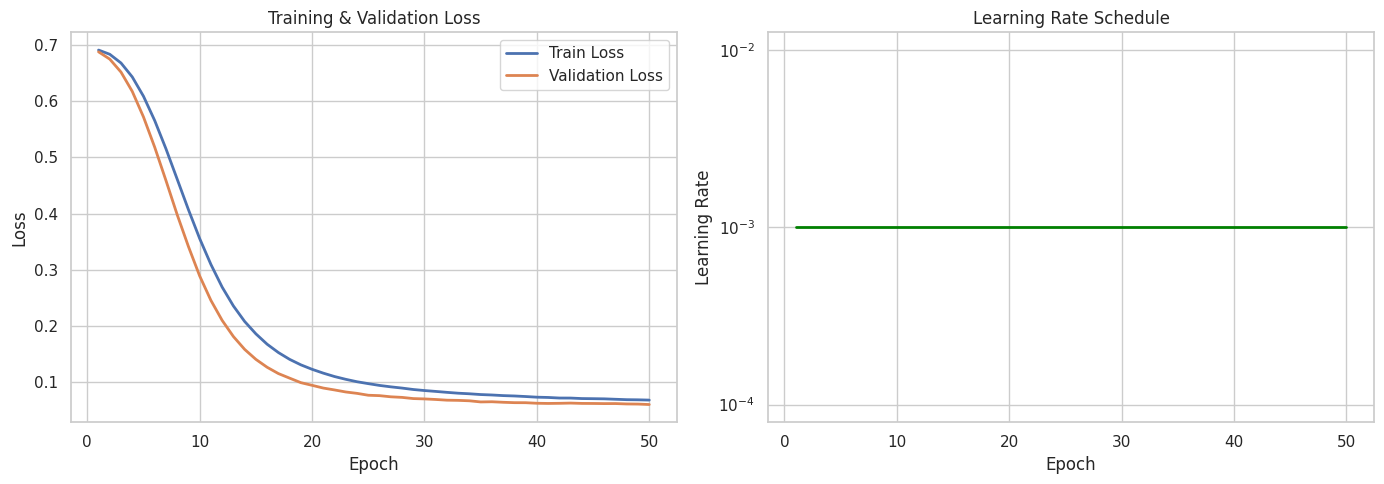

In [111]:
show_training_plots(history)

In [112]:
def show_tsne_embeddings(model, edge_index, num_samples=800):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.manifold import TSNE
    import torch

    sns.set(style="whitegrid")

    model.eval()
    user_emb, item_emb = model(edge_index)

    # Sample users/items
    n_u = min(num_samples // 2, user_emb.size(0))
    n_i = min(num_samples // 2, item_emb.size(0))

    torch.manual_seed(42)
    u_idx = torch.randperm(user_emb.size(0))[:n_u]
    i_idx = torch.randperm(item_emb.size(0))[:n_i]

    embs = torch.cat([user_emb[u_idx], item_emb[i_idx]], dim=0).detach().cpu().numpy()
    labels = ["User"] * n_u + ["Item"] * n_i

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_2d = tsne.fit_transform(embs)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=emb_2d[:, 0],
        y=emb_2d[:, 1],
        hue=labels,
        palette=["#2E86AB", "#A23B72"],
        alpha=0.7,
        s=50,
        edgecolor="black",
        linewidth=0.3,
    )
    plt.title("t-SNE Visualization of User & Item Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

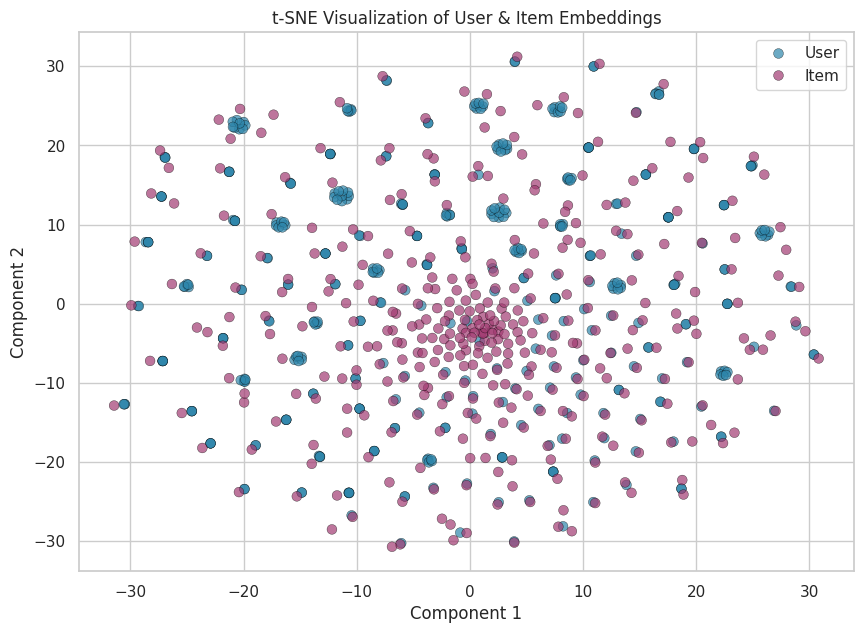

In [113]:
show_tsne_embeddings(model, edge_index)

# **13- Test Recommender**

In [114]:
def test_recommender(model, edge_index, product_to_idx, idx_to_product, user_id=0, k=10):
    """
    Test the trained LightGCN model by generating recommendations for a sample user.
    """
    model.eval()
    user_emb, item_emb = model(edge_index)

    # Compute scores for all items
    user_vec = user_emb[user_id : user_id + 1]
    scores = torch.matmul(user_vec, item_emb.T).squeeze(0)

    # Top‑k recommended item indices
    top_items = torch.topk(scores, k).indices.tolist()

    print(f"\n🔵 Recommended laptops for user {user_id}:")
    print("-" * 60)
    for rank, item_idx in enumerate(top_items, 1):
        product_name = idx_to_product[item_idx]
        print(f"{rank}. {product_name}")

In [115]:
test_recommender(model, edge_index, product_to_idx, idx_to_product, user_id=0, k=10)


🔵 Recommended laptops for user 0:
------------------------------------------------------------
1. Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/Mac OS Monterey)...
2. ASUS Chromebook Intel Celeron Dual Core N4500 - (4 GB/64 GB EM...
3. Lenovo LOQ Intel Core i5 12th Gen 12450HX - (12 GB/512 GB SSD/...
4. ASUS Vivobook Go 15 OLED AMD Ryzen 3 Quad Core 7320U - (8 GB/5...
5. MSI Thin 15 Intel Core i5 12th Gen 12450H - (8 GB/512 GB SSD/W...
6. MSI Modern 15 AMD Ryzen 5 Hexa Core 7530U - (8 GB/512 GB SSD/W...
7. Infinix GT Book Intel Core i5 12th Gen 12450H - (16 GB/512 GB ...
8. Acer Predator Neo Intel Core i5 13th Gen 13500HX - (16 GB/512 ...
9. DELL Inspiron 15 with Backlit Keyboard, Intel Core i5 12th Gen...
10. DELL Inspiron Intel Core i5 11th Gen 1135G7 - (16 GB/512 GB SS...


In [116]:
def plot_recommendations(model, edge_index, idx_to_product, user_id=0, k=10):
    import matplotlib.pyplot as plt
    import seaborn as sns

    model.eval()
    user_emb, item_emb = model(edge_index)

    user_vec = user_emb[user_id : user_id + 1]
    scores = torch.matmul(user_vec, item_emb.T).squeeze(0)

    topk = torch.topk(scores, k)
    item_indices = topk.indices.tolist()
    item_scores = topk.values.tolist()

    product_names = [idx_to_product[i] for i in item_indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=item_scores, y=product_names, palette="viridis")
    plt.title(f"Top-{k} Recommendations for User {user_id}")
    plt.xlabel("Score")
    plt.ylabel("Laptop")
    plt.show()

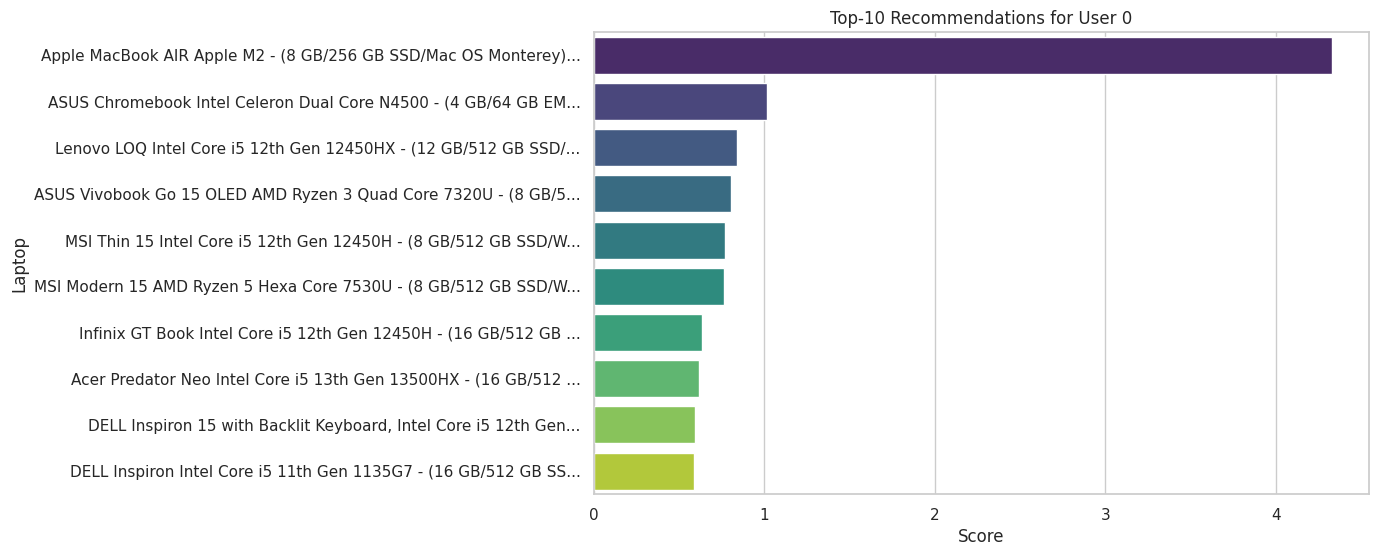

In [117]:
plot_recommendations(model, edge_index, idx_to_product, user_id=0, k=10)